# `pandas` DataFrames and tabular data

In this notebook we give some examples of how we can exploit [pandas](https://pandas.pydata.org/), a very versatile python library which is being used more and more also in HEP. 
In this ministage we are mainly using the `pandas` environment for our analysis. Here we have a first look at some of the main features of a `DataFrame`.

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uproot

First of all, let's import the dataset we are going to use. In this case we take a 300 GeV positrons' sample from the October 2018 beam test. 
Normally HEP data come in the `.root` format, which was born to be directly usable with the [`ROOT` framework](https://root.cern.ch/). We are going to open it into a `pandas` data frame, using [`uproot`](https://github.com/scikit-hep/uproot) to import the ROOT `TTree`.
We also have to define a `key`, which is the name of the `TTree` we want to open.

In [3]:
dirname = '/data_CMS/cms/bonanomi/'
fname = dirname + 'ntuple_435.root'
key='rechitntupler/hits'

In [4]:
branches = [u'rechit_chip', 'rechit_module', 'rechit_channel',
                u'rechit_energy', 'rechit_layer']

In [5]:
ttree = uproot.open(fname)[key]
df = ttree.pandas.df(branches, entrystop=5000)

In [6]:
df.head() # or df[:5]

rechit_chip  rechit_module  rechit_channel  rechit_energy  \
entry subentry                                                              
0     0                   0             78              24      13.849724   
      1                   0             78              52      10.682770   
      2                   1             78              38      16.816133   
      3                   3             78              22       0.933779   
      4                   2             78              62       1.885158   

                rechit_layer  
entry subentry                
0     0                    1  
      1                    1  
      2                    1  
      3                    1  
      4                    1

In [7]:
df = df.reset_index(level=1,drop=True)
df.index.names = ['event']

In [8]:
df[:10]

,rechit_chip,rechit_module,rechit_channel,rechit_energy,rechit_layer
event,,,,,
0,0,78,24,13.849724,1
0,0,78,52,10.682770,1
0,1,78,38,16.816133,1
0,3,78,22,0.933779,1
0,2,78,62,1.885158,1
0,0,90,24,5.122431,2
0,2,90,28,87.813263,2
0,2,90,20,4.447695,2
0,3,90,42,3.045210,2


## Pandas basics

Now that you have in mind the structure of the data frame, we can get some pandas basics knowledge. Let's say we want to look at all the entries in our `df` where the `rechit_energy` is larger than 20 MIPs. In pandas this can be quickly done with a `query` on the `df`:

In [13]:
## we ask for head() because 
## df[sel] is still a df
sel = df['rechit_energy'] > 20
df[sel].head() # or df.query('rechit_energy > 20.')

,rechit_chip,rechit_module,rechit_channel,rechit_energy,rechit_layer
event,,,,,
0,2,90,28,87.813263,2
0,1,89,38,294.619904,3
0,1,89,42,25.813726,3
0,2,88,28,462.703217,4
0,3,88,42,35.341591,4


Here we have learnt how to apply a boolean selection to a data frame. The `sel` object is a pandas Series made of `True` and `False` entries according to whether the selection (`df['rechit_energy'] > 20`) is satisfied or not:

In [16]:
sel.head()

event
0    False
0    False
0    False
0    False
0    False
Name: rechit_energy, dtype: bool

We can also combine multiple selections and create a new df starting from the original one, but with a selection applied on data. Something like this:

In [17]:
## We define some selections
sel_energy = df['rechit_energy'] > 20
sel_layer = df['rechit_layer'] == 12

## We combine the selection together.
## Note that python uses the single & (or | ).
sel_tot = sel_energy & sel_layer

## We create a new df with only the events
## we are interested on.
df_cut = df[sel_tot]

Let's now check the difference in length between these two data frames:

In [20]:
len(df)

5890266

In [21]:
len(df_cut)

61599

## Grouping

We can even group items, perform calculations on some aggregated property, then plot values, just to get an idea of larger scale trends. This property of grouping the elements of the data frame together will turn out to be very useful in our analsys. In `pandas` you can `groupby()` a data frame by items. In our case we might be interested at some *per event* information. Hence, we'd `groupby('event')` our `df`:

In [22]:
gb = df.groupby('event')

In [23]:
## gb is an object from which we can get properties on aggregrated items of df
gb

In [32]:
## Let's say we want to check the min value of 
## a variable per event. 
## Here an example for the reconstructed energy:

gb.agg({'rechit_energy':'min'}).head()

,rechit_energy
event,
0,0.305523
1,0.222531
2,0.146437
3,0.217942
4,0.363993


We can also do combined `groupby` objects. The effect of this will be a grouping over two items. One interesting information in a sampling calorimeter is the longitudinal profile, i.e. the fractional energy deposit per layer. In this way we can have a sort of representation of the longitudinal development of the em shower we are studying. We are going to work on this during our analysis. For now let's try to look at the **hits profile**, meaning the number of hits per layer, per event. When you `groupby` over two items, pandas groups your df for the first item you pass to `groupby` and then it further groups it for the second item: `df.groupby(['item1', 'item2']`.

In [39]:
## When you want to "count" some number in a df 
## (eg number of entries in a row), you can use the .size() method.

hits = df.groupby(['event', 'rechit_layer']).size()

Now `hits` is a pandas `Series` which contains **per event** the information of the number of hits **per layer**:

In [40]:
hits.head()

event  rechit_layer
0      1                5
       2                6
       3               14
       4               23
       5               27
dtype: int64

Data visualisation is something we have to take care when presenting HEP results. The final plots for your report will have to be clear, self-explanatory and easy to be read. For now, let's quickly plot the longitudinal hits profile for one event. To do this we select **the first entry** of `hits`, which corresponds to a series of hits (per layer) for the event at the 0-th place in the `hits` series.

In [44]:
hits_0 = hits[0]

We can now try to plot it. To do so, we use the `matplotlib` library we have seen in the tutorial `0_Numpy_Matplotlib`.

Text(0.5, 1.0, 'Hits per layer prof')

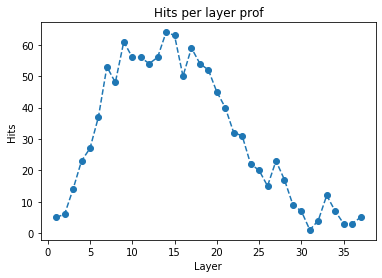

In [54]:
plt.plot(hits_0, 'o--')
plt.xlabel('Layer')
plt.ylabel('Hits')
plt.title('Hits per layer prof')

Ok, we have just checked how the hits profile in the first event of out df looks like. What about the overall profile? Is there a way to reconstruct the full profile for the 200 GeV positron beam we are looking at? Well, we can take the mean of the hits per layer over all the events. Sounds something familiar, right? Let's `groupby`:

In [55]:
## From `hits` we want to extract the mean
## of all the hits in layer 0, 1 ecc:

mean_prf = hits.groupby('rechit_layer').mean()

Text(0.5, 1.0, 'Hits per layer prof')

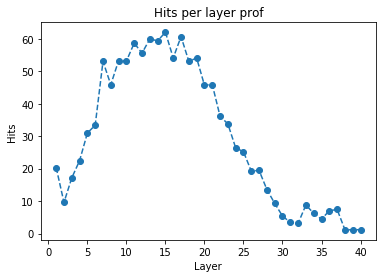

In [56]:
plt.plot(mean_prf, 'o--')
plt.xlabel('Layer')
plt.ylabel('Hits')
plt.title('Hits per layer prof')

Looking at this profile we can already ask ourself some questions:
 * Why do we observe a bump for the first layer? To be understood;
 * Can we get a first hint on where the shower maximum is? 
 * What about the layers? Can we consider a different number of layers?
 
We are going to answer all these questions during our analysis. However it is important to learn this approach to a problem on this kind of data: always try to get a qualitative overall picture. Can you get some features directly from the `df` you have to analyze? Can you answer the questions you have after the first look at the data? ecc...

# Exercises

Take your time to solve this exercises. These questions can help you in learning the analysis tools, in understanding something more about the physics we are (going to) study and to clarify some questions you might have (or to come up with new ones):

 * Where would you expect the shower maximum to be? Why?
 * We are dealing with a 200 GeV positron shower here. What about the calorimeter and its structure: do we really need to consider all the layers as we did above? If not, why?
 * Can you produce the histogram of the energy sums (per event) distribution? (Hint: you can use `groupby` to get the sum of `rechit_energy` for each `event`)
 * In the previous notebook we have learnt how to fit. Can you try to fit the distribution of the previous question with a gaussian?